In this notebook we explore the performance of thee different classifiers: (DecisionTree, BaggingClassifier, and RandomForestClassifiers) on financial data, and compare their performance after finding the optimal hyperparameters (using Optuna) and the optimal feature sets (using Shap).

The objective for optimisations will be profit (defined traditionally), and we backl test the performance of the models over the period 2010 - 2018, and finally compute the Sharpe Ratios, Information Ratios and alpha for the three classifier strategies and the buy-and-hold strategy for SPY.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.preprocessing import StandardScaler

pd.set_option('use_inf_as_na', True)
from collections import Counter

from tqdm import tqdm # to measure progress of for loops

/var/folders/sp/wlr6xm2979l8vx6kjh2z1dk00000gn/T/ipykernel_2415/524871555.py:12: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('use_inf_as_na', True)


In [2]:
# load dataset
raw_data = pd.read_pickle('dataset.pkl')
data = raw_data.drop([x  for x in raw_data.columns if 'fqtr' in x],axis=1)
# restrict companies to market cap > 1 billion 
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
# fill in missing values
data.fillna(0.0,inplace=True)

### Insert a column in dataset based on stock performance
Inserting a column in the dataset where entries are:  
- 1 if the stock return is more than 5% higher than the SPY return  
- 0 if it is between -10% and +5% relative to the SPY return  
- -1 if it is less then -10% relative to the SPY return  

In [3]:
# function to return appropriate values based on performance as detailed above
def f(x):
    if x > 0.05:
        return 1
    elif x < -0.1:
        return -1
    else:
        return 0

In [4]:
# add the new column
data['rel_performance'] = data['pred_rel_return'].apply(f)
# make the date the index
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [5]:
data[['pred_rel_return', 'rel_performance']][100:110]

pred_rel_return  rel_performance
date                                        
2000-04-03         0.261336                1
2000-04-05        -0.337466               -1
2000-04-06         0.272372                1
2000-04-07        -0.645219               -1
2000-04-07         0.192161                1
2000-04-11         0.153474                1
2000-04-11         0.317203                1
2000-04-11        -0.051039                0
2000-04-11         0.028730                0
2000-04-11         0.095712                1

In [6]:
print(data.index)

DatetimeIndex(['2000-02-09', '2000-02-09', '2000-02-10', '2000-02-11',
               '2000-02-15', '2000-02-16', '2000-02-16', '2000-02-16',
               '2000-02-16', '2000-02-16',
               ...
               '2018-12-21', '2018-12-21', '2018-12-21', '2018-12-21',
               '2018-12-21', '2018-12-21', '2018-12-21', '2018-12-21',
               '2018-12-21', '2018-12-24'],
              dtype='datetime64[ns]', name='date', length=111468, freq=None)


### Split the data into training, validation, and test
- Data for training period is from 2007 to 2009 (inclusive, i.e. 3 years)
- Data for validation period is 1 quarter after end of training period
- Data for test period is immediately proceeding the training period

In [7]:
df_1 = data.loc['2007-01-01':'2010-01-01']
df_valid = data.loc['2010-04-01':'2010-07-01']
df_test = data.loc['2010-07-01':'2010-10-01']

In [8]:
train_1 = df_1.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

valid = df_valid.reset_index().drop(['ticker','date',
                                    'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

test = df_test.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

In [9]:
# Obtain the y values for each data split
train_1_stock_returns = df_1['next_period_return']
valid_stock_returns = df_valid['next_period_return']
test_stock_returns = df_test['next_period_return']

y_1 = df_1['rel_performance']
y_valid = df_valid['rel_performance']
y_test = df_test['rel_performance']

y_1 = y_1.values
y_valid = y_valid.values
y_test = y_test.values

### Import Optuna to find the optimal hyperparameters for the classifiers

In [10]:
import optuna
from optuna.trial import Trial
# optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings
warnings.filterwarnings("ignore")

## Defining the Optuna objective function for our 3 classifiers:
- DecisionTree classifier
- Bagging classifier
- RandomForest classifier

Note that in each case we are optimizing for the profit rather than the accuracy

In [11]:
def objective_tree(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    t_min_samples_leaf = trial.suggest_int('min_samples_leaf',100,1200,step=200)
    t_max_depth = trial.suggest_int('max_depth',5,25,step=5)
    
    tree_clf = DecisionTreeClassifier(min_samples_leaf = t_min_samples_leaf,max_depth=t_max_depth,random_state=123)
    tree_clf.fit(train,labels)

    preds = tree_clf.predict(val)
    profit = (preds * val_rets).sum()

    return profit

In [12]:
def objective_bagging(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    t_min_samples_leaf = trial.suggest_int('min_samples_leaf',100,1200,step=200)
    t_max_depth = trial.suggest_int('max_depth',5,25,step=5)
    t_n_estimators = trial.suggest_int('n_estimators',5,50,step=5)

    t_clf = DecisionTreeClassifier(min_samples_leaf = t_min_samples_leaf,max_depth=t_max_depth,random_state=123)
    bg_clf = BaggingClassifier(t_clf,n_estimators=t_n_estimators,random_state=123,n_jobs=1)
    bg_clf.fit(train,labels)

    preds = bg_clf.predict(val)
    profit = (preds * val_rets).sum()

    return profit

In [13]:
def objective_rf(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    rf_n_estimators = trial.suggest_int('n_estimators', 10,40,step=5)
    rf_max_features = trial.suggest_categorical('max_features',['sqrt','log2'])
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf',800,2400,step=800)
    rf_max_depth = trial.suggest_int('max_depth',4,15)
    
    rf_clf = RandomForestClassifier(n_estimators=rf_n_estimators,
                                    max_depth=rf_max_depth,
                                    min_samples_leaf=rf_min_samples_leaf,
                                    max_features=rf_max_features,random_state=123)
    rf_clf.fit(train,labels)

    preds = rf_clf.predict(val)
    profit = (preds * val_rets).sum()
 
    return profit

In [14]:
study_tree = optuna.create_study(direction="maximize")
study_bagging = optuna.create_study(direction="maximize")
study_rf = optuna.create_study(direction="maximize")

[I 2024-02-04 20:38:13,061] A new study created in memory with name: no-name-9c8e0ef4-6fad-4938-b3df-43bc4decf7d1
[I 2024-02-04 20:38:13,061] A new study created in memory with name: no-name-32573266-7473-4929-8fd1-9ea6b5732dfe
[I 2024-02-04 20:38:13,061] A new study created in memory with name: no-name-dabe04c2-f647-4709-824c-d3b1f871bb0e


### Run optimizations to find optimal parameters

In [15]:
from functools import partial

In [16]:
%%time
study_tree.optimize(partial(objective_tree,train=train_1,labels=y_1,val=valid,val_labels=y_valid,val_rets=valid_stock_returns), n_trials=200,n_jobs=-1)

[I 2024-02-04 20:38:14,225] Trial 8 finished with value: -42.11555900000003 and parameters: {'min_samples_leaf': 1100, 'max_depth': 15}. Best is trial 8 with value: -42.11555900000003.
[I 2024-02-04 20:38:14,260] Trial 6 finished with value: -20.87378900000001 and parameters: {'min_samples_leaf': 700, 'max_depth': 5}. Best is trial 6 with value: -20.87378900000001.
[I 2024-02-04 20:38:14,283] Trial 3 finished with value: -33.88995700000003 and parameters: {'min_samples_leaf': 900, 'max_depth': 15}. Best is trial 6 with value: -20.87378900000001.
[I 2024-02-04 20:38:14,289] Trial 1 finished with value: -33.88995700000003 and parameters: {'min_samples_leaf': 900, 'max_depth': 25}. Best is trial 6 with value: -20.87378900000001.
[I 2024-02-04 20:38:14,361] Trial 2 finished with value: -33.88995700000003 and parameters: {'min_samples_leaf': 900, 'max_depth': 15}. Best is trial 6 with value: -20.87378900000001.
[I 2024-02-04 20:38:14,408] Trial 4 finished with value: -20.46544500000001 and 

CPU times: user 3min 48s, sys: 2.72 s, total: 3min 51s
Wall time: 26.2 s


In [17]:
%%time
study_bagging.optimize(partial(objective_bagging,train=train_1,labels=y_1,val=valid,val_labels=y_valid,val_rets=valid_stock_returns), n_trials=200,n_jobs=-1)

[I 2024-02-04 20:38:43,087] Trial 9 finished with value: -33.29038000000004 and parameters: {'min_samples_leaf': 300, 'max_depth': 5, 'n_estimators': 5}. Best is trial 9 with value: -33.29038000000004.
[I 2024-02-04 20:38:44,820] Trial 0 finished with value: -37.487501000000044 and parameters: {'min_samples_leaf': 900, 'max_depth': 10, 'n_estimators': 10}. Best is trial 9 with value: -33.29038000000004.
[I 2024-02-04 20:38:48,573] Trial 3 finished with value: -34.22570200000003 and parameters: {'min_samples_leaf': 700, 'max_depth': 5, 'n_estimators': 15}. Best is trial 9 with value: -33.29038000000004.
[I 2024-02-04 20:38:50,427] Trial 1 finished with value: -38.103020000000036 and parameters: {'min_samples_leaf': 900, 'max_depth': 5, 'n_estimators': 20}. Best is trial 9 with value: -33.29038000000004.
[I 2024-02-04 20:38:51,806] Trial 6 finished with value: -34.67733300000003 and parameters: {'min_samples_leaf': 700, 'max_depth': 15, 'n_estimators': 20}. Best is trial 9 with value: -3

CPU times: user 38min 43s, sys: 15 s, total: 38min 58s
Wall time: 4min 25s


In [18]:
%%time
study_rf.optimize(partial(objective_rf,train=train_1,labels=y_1,val=valid,val_labels=y_valid,val_rets=valid_stock_returns), n_trials=200,n_jobs=-1)

[I 2024-02-04 20:43:05,336] Trial 4 finished with value: -40.74410800000003 and parameters: {'n_estimators': 15, 'max_features': 'log2', 'min_samples_leaf': 800, 'max_depth': 11}. Best is trial 4 with value: -40.74410800000003.
[I 2024-02-04 20:43:05,346] Trial 6 finished with value: -39.25296700000003 and parameters: {'n_estimators': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1600, 'max_depth': 6}. Best is trial 6 with value: -39.25296700000003.
[I 2024-02-04 20:43:05,413] Trial 8 finished with value: -40.00959700000004 and parameters: {'n_estimators': 10, 'max_features': 'sqrt', 'min_samples_leaf': 800, 'max_depth': 15}. Best is trial 6 with value: -39.25296700000003.
[I 2024-02-04 20:43:05,451] Trial 9 finished with value: -37.859784000000026 and parameters: {'n_estimators': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2400, 'max_depth': 15}. Best is trial 9 with value: -37.859784000000026.
[I 2024-02-04 20:43:05,464] Trial 7 finished with value: -38.53366700000004 and param

CPU times: user 1min 14s, sys: 5 s, total: 1min 19s
Wall time: 12.1 s


### Instantiate the classifiers with the best parameters

In [19]:
print("Best parameters for decision tree: ", study_tree.best_params)
print("Best parameters for bagging: ", study_bagging.best_params)
print("Best parameters for random forest: ", study_rf.best_params)

Best parameters for decision tree:  {'min_samples_leaf': 700, 'max_depth': 25}
Best parameters for bagging:  {'min_samples_leaf': 100, 'max_depth': 10, 'n_estimators': 5}
Best parameters for random forest:  {'n_estimators': 30, 'max_features': 'sqrt', 'min_samples_leaf': 800, 'max_depth': 15}


In [20]:
t_clf = DecisionTreeClassifier(**study_tree.best_params,random_state=123)

In [21]:
tree_cfl = DecisionTreeClassifier(**{'min_samples_leaf': study_bagging.best_params['min_samples_leaf'],
                                     'max_depth': study_bagging.best_params['max_depth']})
bg_clf = BaggingClassifier(tree_cfl,n_estimators=study_bagging.best_params['n_estimators'],random_state=123 ,n_jobs=-1)

In [22]:
rf_clf = RandomForestClassifier(**study_rf.best_params)

### Train each of the classifiers

In [23]:
t_clf.fit(train_1,y_1)

DecisionTreeClassifier(max_depth=25, min_samples_leaf=700, random_state=123)

In [24]:
bg_clf.fit(train_1,y_1)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10,
                                                   min_samples_leaf=100),
                  n_estimators=5, n_jobs=-1, random_state=123)

In [25]:
rf_clf.fit(train_1,y_1)

RandomForestClassifier(max_depth=15, min_samples_leaf=800, n_estimators=30)

### Back test the performance of the models over the period 2010 - 2018

In [26]:
start_dates = [pd.to_datetime('2010-01-01') + pd.DateOffset(months = 3*i) for i in range(21)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]
# So the first period is [2010 Jan 1 - 2013 Jan 1], and the last period is [2015 Jan 1 - 2018 Jan 1]

In [27]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d + pd.DateOffset(months=6):d+pd.DateOffset(months = 9)] for d in end_dates]

training_labels = [d['rel_performance'].values for d in training_frames]

training_stock_returns = [d['next_period_return'].values for d in training_frames]
test_stock_returns = [d['next_period_return'] for d in test_frames]

In [28]:
training_data = [df.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance', 'pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for df in training_frames]
valid_data = [df.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for df in valid_frames]
test_data = [df.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for df in test_frames]

In [29]:
# dictionary to store performance and returns
xs = {'t':[1], 'bg':[1], 'rf':[1]}
rets = {'t':[], 'bg':[], 'rf':[]}
models = {'t':t_clf, 'bg':bg_clf, 'rf':rf_clf}

for i in tqdm(range(len(start_dates)-1)):
    for key, model in models.items():
        model.fit(training_data[i],training_labels[i])
        
        preds = model.predict(test_data[i])
        profit_i = (preds*test_stock_returns[i]).sum()
        
        rets[key].append(profit_i)
        num_names = len(test_data[i])
        xs[key].append(xs[key][i] + (xs[key][i]/num_names)*profit_i)


100%|███████████████████████████████████████████| 20/20 [01:28<00:00,  4.41s/it]


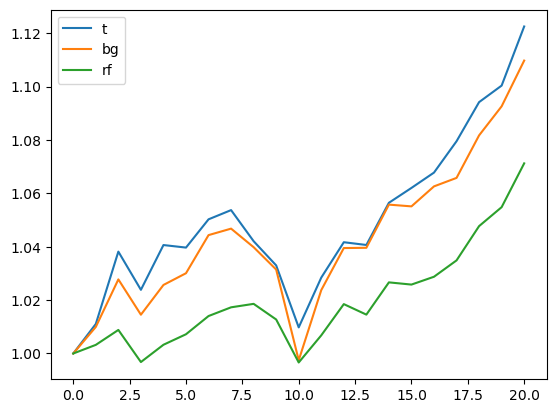

In [30]:
for key, x_list in xs.items():
    plt.plot(x_list, label = key);
plt.legend()

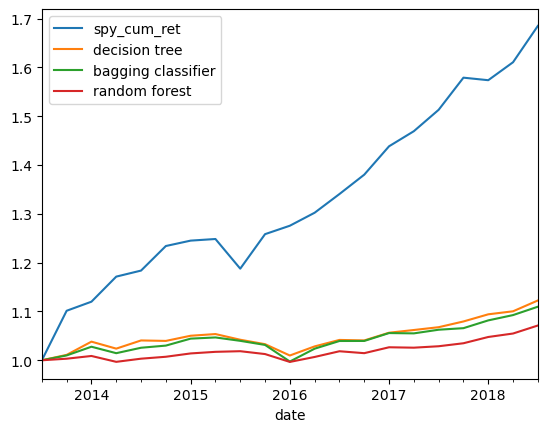

In [31]:
# Compare to buy and hold of SPY
SPY = pd.read_pickle(r'SPY_cum_ret.pkl')
SPY = SPY.loc['2013-07-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0]+1)
SPY['decision tree'] = xs['t']
SPY['bagging classifier'] = xs['bg']
SPY['random forest'] = xs['rf']
SPY.plot();

### Now we can compute the Shapley values for these models and see how the performance changes

### Finding the features with non zero Shapley values

In [32]:
# Retrain the models using the original training set (i.e. before backtesting)
t_clf.fit(train_1,y_1)
bg_clf.fit(train_1,y_1)
rf_clf.fit(train_1,y_1)

RandomForestClassifier(max_depth=15, min_samples_leaf=800, n_estimators=30)

In [33]:
# Obtain the feature importances
def tree_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'feat_imp':m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

def bagging_feat_importance(m, df):
    feature_importances = []
    for est in m.estimators_:
        fi = est.feature_importances_
        feature_importances.append(fi)
    feature_importances = np.array(feature_importances)
        
    return pd.DataFrame({'cols':train_1.columns, 'feat_imp':np.mean(feature_importances,axis=0)}
                       ).sort_values('feat_imp', ascending=False)

def randomforest_feat_importances(m, df):
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp': m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

In [34]:
t_fi = tree_feat_importance(t_clf,train_1)
bg_fi = bagging_feat_importance(bg_clf,train_1)
rf_fi = randomforest_feat_importances(rf_clf,train_1)

In [35]:
# Only use features that have positive feature importance
t_features = t_fi[(t_fi['feat_imp'] > 0.00)]
bg_features = bg_fi[(bg_fi['feat_imp'] > 0.00)]
rf_features = rf_fi[(rf_fi['feat_imp'] > 0.00)]

In [36]:
train_t = train_1[t_features['cols'].values]
valid_t = valid[t_features['cols'].values]
valid_t['returns'] = valid_stock_returns.values

train_bg = train_1[bg_features['cols'].values]
valid_bg = valid[bg_features['cols'].values]
valid_bg['returns'] = valid_stock_returns.values

train_rf = train_1[rf_features['cols'].values]
valid_rf = valid[rf_features['cols'].values]
valid_rf['returns'] = valid_stock_returns.values

In [37]:
print(f"Number of features used for decision tree classifier reduced from: {train_1.shape[1]} to {train_t.shape[1]}")
print(f"Number of features used for bagging classifier reduced from      : {train_1.shape[1]} to {train_bg.shape[1]}")
print(f"Number of features used for random forest classifier reduced from: {train_1.shape[1]} to {train_rf.shape[1]}")

Number of features used for decision tree classifier reduced from: 725 to 16
Number of features used for bagging classifier reduced from      : 725 to 133
Number of features used for random forest classifier reduced from: 725 to 121


In [38]:
# Retrain the classifiers using the new feature set
t_clf.fit(train_t,y_1)
bg_clf.fit(train_bg,y_1)
rf_clf.fit(train_rf,y_1)

RandomForestClassifier(max_depth=15, min_samples_leaf=800, n_estimators=30)

In [39]:
import shap

def model_t(features):
    tree_features = features[features.columns[:-1].values]
    pred = t_clf.predict(tree_features)
    ret = pred * features[features.columns[-1]]
    return ret

def model_bg(features):
    bagging_features = features[features.columns[:-1].values]
    pred = bg_clf.predict(bagging_features)
    ret = pred * features[features.columns[-1]]
    return ret

def model_rf(features):
    rf_features = features[features.columns[:-1].values]
    pred = rf_clf.predict(rf_features)
    ret = pred * features[features.columns[-1]]
    return ret

PermutationExplainer explainer: 1442it [00:54, 21.85it/s]                       


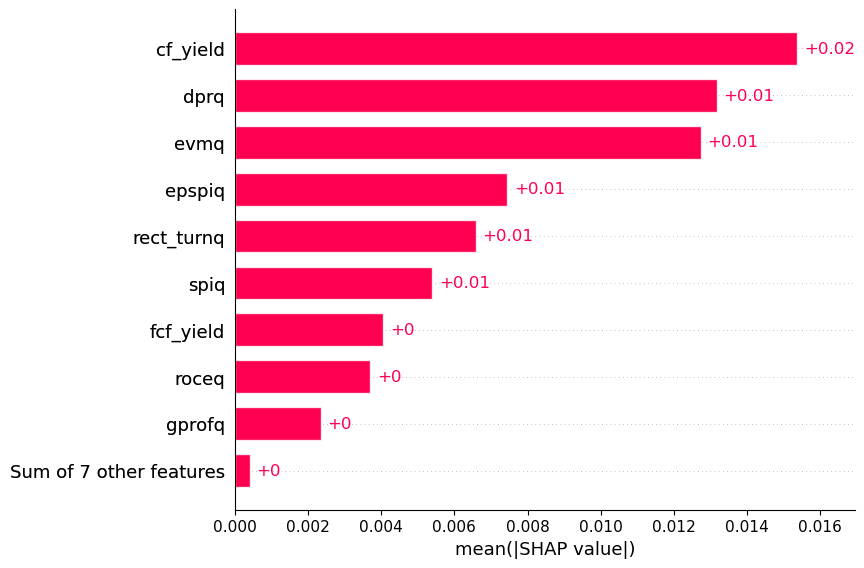

In [40]:
# Shapley for tree classifier
model_t(valid_t)
t_explainer = shap.explainers.Permutation(model_t,valid_t)
t_shap_values = t_explainer(valid_t,max_evals=2000)
shap.plots.bar(t_shap_values[:,:-1],max_display=10)

PermutationExplainer explainer: 1442it [35:30,  1.48s/it]                       


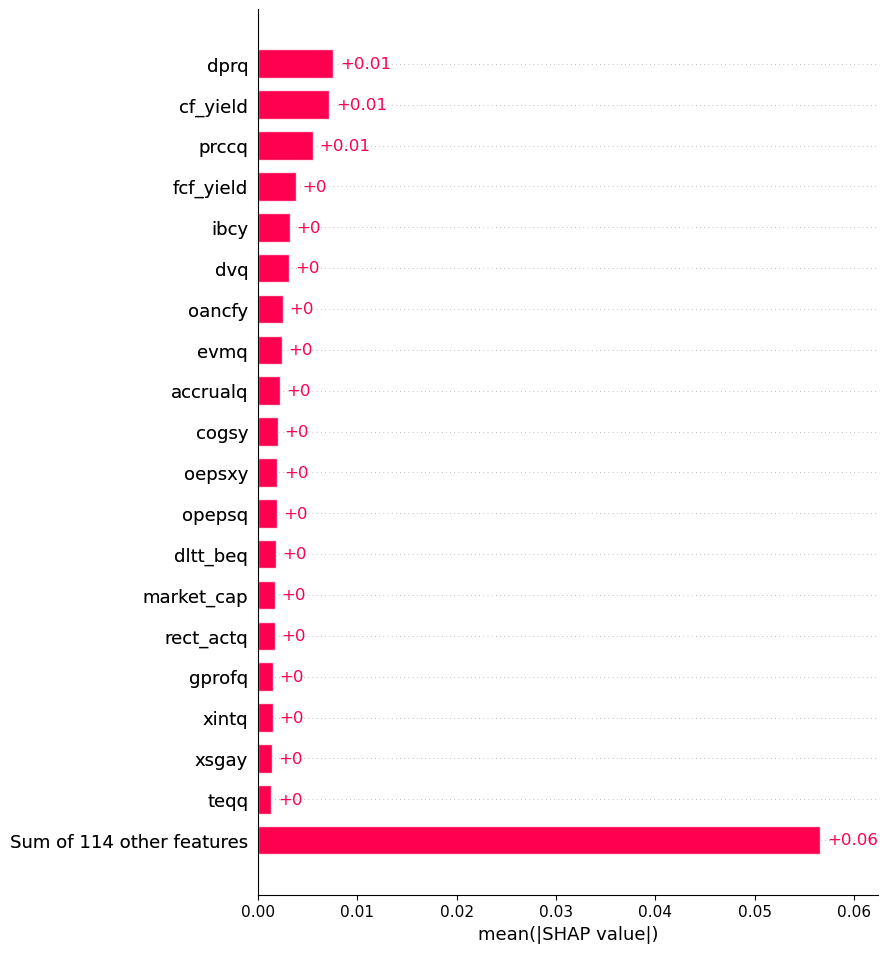

In [41]:
# Shapley for bagging classifier
model_bg(valid_bg)
bg_explainer = shap.explainers.Permutation(model_bg,valid_bg)
bg_shap_values = bg_explainer(valid_bg,max_evals=2000)
shap.plots.bar(bg_shap_values[:,:-1],max_display=20)

PermutationExplainer explainer: 1442it [05:45,  4.06it/s]                       


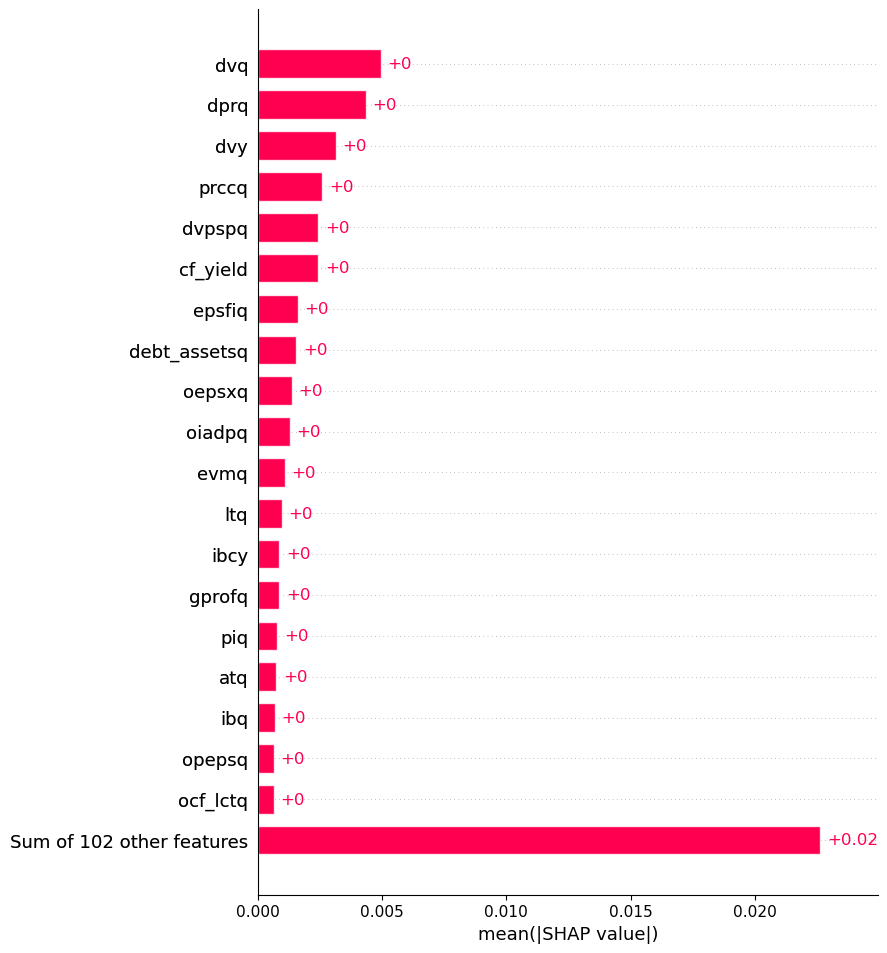

In [42]:
# Shapley for random forest classifier
model_rf(valid_rf)
rf_explainer = shap.explainers.Permutation(model_rf,valid_rf)
rf_shap_values = rf_explainer(valid_rf,max_evals=2000)
shap.plots.bar(rf_shap_values[:,:-1],max_display=20)

### Retrain the models with the features that have non-zero Shapley values

In [43]:
t_cols = t_features['cols'].values
t_shap_cols = t_cols[np.abs(t_shap_values[:,:-1].values).mean(axis=0)>0.000]

bg_cols = bg_features['cols'].values
bg_shap_cols = bg_cols[np.abs(bg_shap_values[:,:-1].values).mean(axis=0)>0.000]

rf_cols = rf_features['cols'].values
rf_shap_cols = rf_cols[np.abs(rf_shap_values[:,:-1].values).mean(axis=0)>0.000]

In [44]:
# Retrain the classifiers using the new feature set
t_clf.fit(train_t[t_shap_cols],y_1)
bg_clf.fit(train_bg[bg_shap_cols],y_1)
rf_clf.fit(train_rf[rf_shap_cols],y_1)

RandomForestClassifier(max_depth=15, min_samples_leaf=800, n_estimators=30)

### Back test over the period 2010 - 2018

In [45]:
scalers = [StandardScaler() for _ in range(len(training_data))]

def get_opt_data(shap_cols):
    opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(training_data))]
    opt_valid_data = [pd.DataFrame(scalers[i].transform(valid_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(valid_data))]
    opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(test_data))]
    return opt_training_data, opt_valid_data, opt_test_data

t_opt_training_data, t_opt_valid_data, t_opt_test_data = get_opt_data(t_shap_cols)
bg_opt_training_data, bg_opt_valid_data, bg_opt_test_data = get_opt_data(bg_shap_cols)
rf_opt_training_data, rf_opt_valid_data, rf_opt_test_data = get_opt_data(rf_shap_cols)

In [46]:
# dictionary to store performance and returns
opt_xs = {'t':[1], 'bg':[1], 'rf':[1]}
opt_rets = {'t':[], 'bg':[], 'rf':[]}
models = {'t':t_clf, 'bg':bg_clf, 'rf':rf_clf}

# dictionary of training and test data for each classifier model
opt_training_data = {'t':t_opt_training_data, 'bg':bg_opt_training_data, 'rf':rf_opt_training_data}
opt_test_data = {'t':t_opt_test_data, 'bg':bg_opt_test_data, 'rf':rf_opt_test_data}

for i in tqdm(range(len(start_dates)-1)):
    for key, model in models.items():
        model.fit(opt_training_data[key][i],training_labels[i])
        
        preds = model.predict(opt_test_data[key][i])
        profit_i = (preds*test_stock_returns[i]).sum()
        
        opt_rets[key].append(profit_i)
        num_names = len(opt_test_data[key][i])
        opt_xs[key].append(opt_xs[key][i] + (opt_xs[key][i]/num_names)*profit_i)

100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.65s/it]


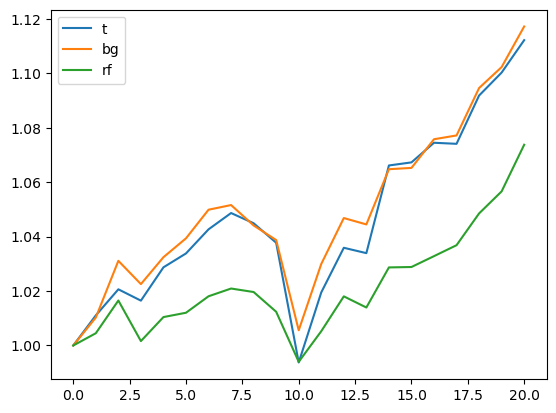

In [47]:
for key, x_list in opt_xs.items():
    plt.plot(x_list, label = key);
plt.legend()

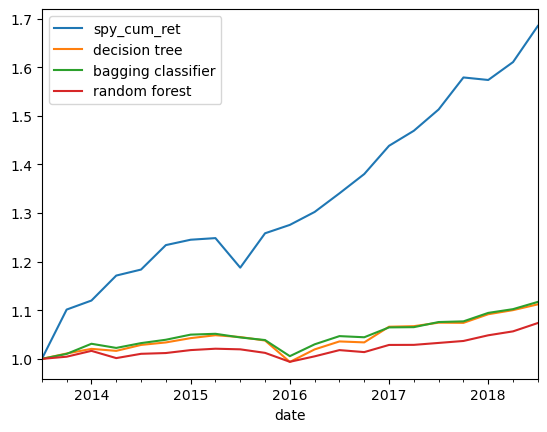

In [48]:
# Compare to buy and hold of SPY
SPY = pd.read_pickle(r'SPY_cum_ret.pkl')
SPY = SPY.loc['2013-07-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0]+1)
SPY['decision tree'] = opt_xs['t']
SPY['bagging classifier'] = opt_xs['bg']
SPY['random forest'] = opt_xs['rf']
SPY.plot();

### Compute the Sharpe Ratio, Information Ratio, and alpha for the strategies and for the buy-and-hold strategy for SPY

In [49]:
strategies = {'decision tree' :     "Decision Tree Strategy     ", 
              'bagging classifier': "Bagging Classifier Strategy",
              'random forest' :     "Random Forest Strategy     ",
              'spy_cum_ret':        "SPY Buy-and-hold Strategy  "}

In [50]:
# Sharpe Ratio
for key, strat in strategies.items():
    strategy_mean_ret = (SPY[key] - 1).diff().mean()
    strategy_std = (SPY[key] - 1).diff().std()
    strategy_sr = strategy_mean_ret/strategy_std
    print(strat, ' Sharpe Ratio:', strategy_sr)

Decision Tree Strategy       Sharpe Ratio: 0.36664541127858863
Bagging Classifier Strategy  Sharpe Ratio: 0.44052597772678764
Random Forest Strategy       Sharpe Ratio: 0.39177764778019614
SPY Buy-and-hold Strategy    Sharpe Ratio: 0.9869583355280026


In [51]:
# Information Ratio
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

for key, strat in list(strategies.items())[:-1]:
    strategy_ret = (SPY[key] - 1).diff().values[1:]
    beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
    residual_ret = strategy_ret - beta * spy_ret
    IR = np.mean(residual_ret)/np.std(residual_ret)
    print(strat, ' Information Ratio:', IR)

Decision Tree Strategy       Information Ratio: 0.24407902834503367
Bagging Classifier Strategy  Information Ratio: 0.2944040595301684
Random Forest Strategy       Information Ratio: 0.3438453383357505


In [52]:
# Alpha
for key, strat in list(strategies.items())[:-1]:
    strategy_ret = (SPY[key] - 1).diff().values[1:]
    beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
    residual_ret = strategy_ret - beta * spy_ret
    alpha = np.mean(residual_ret)
    print(strat, ' alpha:', alpha)

Decision Tree Strategy       alpha: 0.003612123226636429
Bagging Classifier Strategy  alpha: 0.003775197633395072
Random Forest Strategy       alpha: 0.003151106466031975
